In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Rescaling
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator

2023-09-19 08:20:56.178681: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 08:20:56.210438: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 08:20:56.211339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 08:20:56.833404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/share/Machine Learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"
os.system('echo $XLA_FLAGS')
os.system('echo $TF_GPU_ALLOCATOR')

--xla_gpu_cuda_data_dir=/usr/lib/cuda
cuda_malloc_async


0

In [3]:
print(tf.__version__)

2.13.0


In [4]:
data_dir = pathlib.Path('./Datasets/lung/').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

977


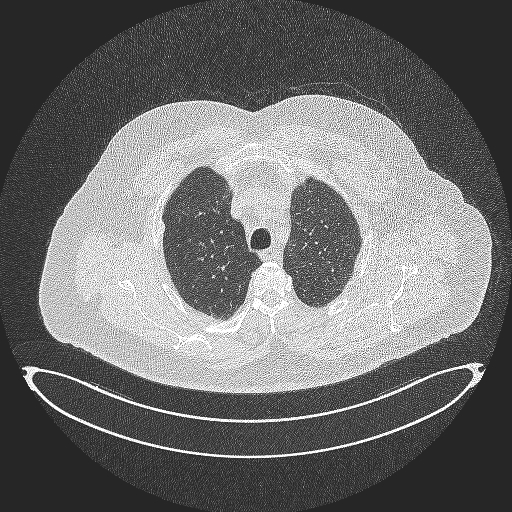

In [5]:
bengin=list(data_dir.glob('Normal cases/*'))
PIL.Image.open(str(bengin[1]))

In [6]:
# train_ds=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True).flow_from_directory(directory=path,target_size=(512,512),batch_size=)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(512, 512),
  batch_size=32)

Found 1097 files belonging to 3 classes.
Using 768 files for training.


In [7]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(512, 512),
  batch_size=32)

Found 1097 files belonging to 3 classes.
Using 329 files for validation.


In [9]:
class_names_ = train_ds.class_names # type: ignore
print(class_names_)

['Bengin cases', 'Malignant cases', 'Normal cases']


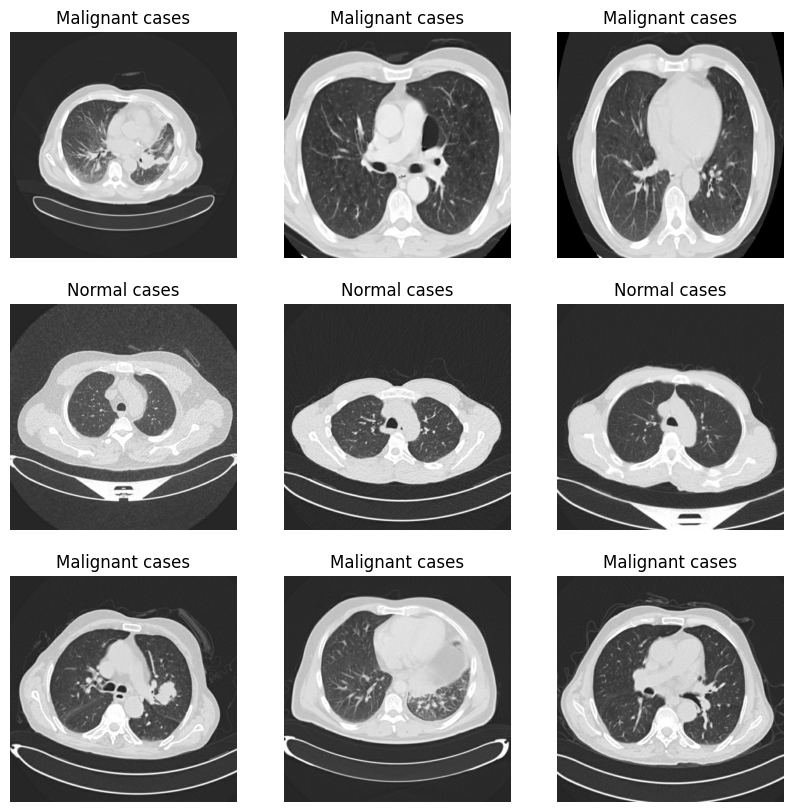

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # type: ignore
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 3)
(32,)


In [11]:
num_classes = 2

# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(4, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])
model=Sequential()
model.add(Conv2D(filters= 8,kernel_size=(3,3),activation='relu',input_shape=(512,512,3)))
model.add(Conv2D(filters= 16,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters= 32,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
# model.add(Dropout(rate=0.25))
model.add(Dense(3))
model.summary()
# model=Sequential()
# model.add(Conv2D(32,(3,3),activation='relu',input_shape=(512,512,3)))
# model.add(MaxPool2D(2,2))
# model.add(Flatten())
# model.add(Dense(100,activation='relu'))
# model.add(Dense(10,activation='softmax'))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
names=train_ds.class_names
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) # type: ignore
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # type: ignore

In [14]:

# from tensorflow.keras.optomize import
model.compile(
  optimizer='adam',
  # optimizer=SGD(learning_rate=1e-4, momentum=0.9),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  # loss='categorical_crossentropy',
  metrics=['accuracy'])
# print(tf.keras.metrics.SensitivityAtSpecificity(0.5, class_id=None, name=None, dtype=None))
m = tf.keras.metrics.SensitivityAtSpecificity(
        0.4, num_thresholds=200)
m.update_state([0, 0, 1, 1], [0, 0.5, 0.3, 0.9])
print('Result with num_thresholds = %d: %.1f' %(200, m.result().numpy()))

Result with num_thresholds = 200: 1.0


In [14]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

# model.summary()

Epoch 1/3
22/24 [==========================>...] - ETA: 1s - loss: 0.8292 - accuracy: 0.6562Epoch 1/10


2023-09-18 23:56:23.813855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-18 23:56:25.147938: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8eecdf86f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-18 23:56:25.147983: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-09-18 23:56:25.151604: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-18 23:56:25.229120: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 26s 1s/step - loss: 0.8105 - accuracy: 0.6732 - val_loss: 0.5829 - val_accuracy: 0.8024
Epoch 2/3
24/24 [==============================] - 24s 981ms/step - loss: 0.4663 - accuracy: 0.8659 - val_loss: 0.3603 - val_accuracy: 0.8784
Epoch 3/3
24/24 [==============================] - 24s 999ms/step - loss: 0.2610 - accuracy: 0.9206 - val_loss: 0.2428 - val_accuracy: 0.8997


In [15]:
img=load_img('Datasets/lung/Bengin cases/Bengin case (3).jpg')
arr=img_to_array(img)
for image_batch ,labels_batch in val_ds:
    print(image_batch,labels_batch)
# pred=model.predict(val_ds.train_)

tf.Tensor(
[[[[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]

  [[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]

  [[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]

  ...

  [[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]

  [[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]

  [[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]]


 [[[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]

  [[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]]

  [[38. 38. 38.]
   [38. 38. 38.]
   [38. 38. 38.]
   ...
   [38. 38. 38.]
   [38. 38. 38.]


In [33]:
from keras.preprocessing.image import load_img,img_to_array
path="./Datasets/lung/Malignant cases/Malignant case (67).jpg"
img=load_img(path,target_size=(512,512))
arr=img_to_array(img)
# arr.shape
arr=np.expand_dims(arr,axis=0)
pred=model.predict(arr)
pred_1=list(pred[0])
print(pred_1)
ans=list(names)
print(ans)
print(ans[pred_1.index(max(pred_1))])

1/1 [==============================] - 0s 13ms/step
[6.039423, -7.860285]
['Malignant cases', 'Normal cases']
Malignant cases
